# Test of bespoke neural network

Import necessary modules:

In [ ]:
from classes.MyModel import MyModel
import torch
import torch.nn as nn
import math as math
from pathlib import Path
from torchviz import make_dot

from modules.helper_functions_tsp import (find_problem_size,
                                          find_distances_array,
                                          cost_fn_fact, 
                                          cost_fn_tensor, 
                                          hot_start, 
                                          hot_start_list_to_string)

from modules.config import GRAPH_DIR
from modules.helper_ML_functions import (find_device, 
                                         get_ready_to_train,
                                         train_model)

from modules.graph_functions import (plot_sine_activation,
                                     plot_model_training)

Set up constants:

In [ ]:
LOCATIONS = 8                       #locations in problem
DECODING_FORMULATION = 'original'   #decoding formulation
                                    #options: 'original', 'new'
GRAY = False                        #gray code  
STD_DEV = 0.5                       #standard deviation for weight randomization
NUM_EPOCHS = 500                    #number of epochs for training
NUM_LAYERS = 2                      #number of layers in the mode
LR = 0.0001                         #Learning rate
VERBOSE = False                     #controls how much output the model produces
BATCH_SIZE = 64                     #size of input tensor.  Reduces randomness
MOMENTUM = 0.000                    #momentum for optimizer
WEIGHT_DECAY = 0.0002               #importance of L2 regularization in optimiser
OPTIMIZER = 'SGD'                   #optimizer to use
                                    #options: 'Adam', 'SGD', 'RMSprop
     

Read in data, report on data read and validate distance array:

In [5]:
distance_array, best_dist = find_distances_array(LOCATIONS, print_comments=True)

Reading distance data
Data will be read from filename networks\sim_dist_8_locs.txt.
It is known that the shortest distance is 277.2


Evaluate cost function and clear cache:

In [6]:
cost_fn = cost_fn_fact(LOCATIONS, distance_array, GRAY, method = DECODING_FORMULATION, verbose=VERBOSE)
cost_fn.clear_cache()

Check if CUDA is available and set the device

In [7]:
device = find_device()
print(f"Using device: {device}")

Using device: cuda


Find problem size:

In [8]:
qubits = find_problem_size(LOCATIONS, DECODING_FORMULATION)
print(f'There are {qubits} qubits needed for {LOCATIONS} locations in the {DECODING_FORMULATION} formulation.')

There are 14 qubits needed for 8 locations in the original formulation.


Find a hot start using a lazy classical algorithm and find the quality of the hot start:

In [9]:
hot_start_list = hot_start(distance_array, LOCATIONS)
print(f'The hot start location list is {hot_start_list}')
bin_hot_start_list =  hot_start_list_to_string(hot_start_list, LOCATIONS, GRAY, DECODING_FORMULATION)
print(f'This is equivalent to a binary list: {bin_hot_start_list}')
bin_hot_start_list_tensor = torch.tensor([bin_hot_start_list])
print(f'bin_hot_start_list_tensor = {bin_hot_start_list_tensor}')
distance_tensor = cost_fn_tensor(bin_hot_start_list_tensor, cost_fn).clone().detach().requires_grad_(True)
print(f'The hot start distance is {float(distance_tensor):.2f}, compared to a best distance of {best_dist:.2f}.')

The hot start location list is [0, 3, 5, 4, 1, 6, 7, 2]
This is equivalent to a binary list: [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1]
bin_hot_start_list_tensor = tensor([[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1]])
The hot start distance is 315.80, compared to a best distance of 277.20.


Set up input as repeated hot start tensor calculated above:

In [10]:
unrepeated_input = bin_hot_start_list_tensor.float().to(device)
my_input = unrepeated_input.repeat(BATCH_SIZE, 1).requires_grad_(True)

Set up model with gradient required:

In [11]:

model = MyModel(qubits, NUM_LAYERS, STD_DEV, cost_fn).to(device)
for param in model.parameters():
    param.requires_grad = True

Report on model parameters:

In [12]:
total_params = sum(
	param.numel() for param in model.parameters()
)
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)

print(f'There are {total_params} parameters in total, of which {trainable_params} are trainable')

for name, param in model.named_parameters():
    print(f"Parameter {name} requires_grad: {param.requires_grad}")

There are 420 parameters in total, of which 420 are trainable
Parameter fc1.weight requires_grad: True
Parameter fc1.bias requires_grad: True
Parameter fc2.weight requires_grad: True
Parameter fc2.bias requires_grad: True


Test the Sine activation function and print out a graph:

Plot the sine activation function:

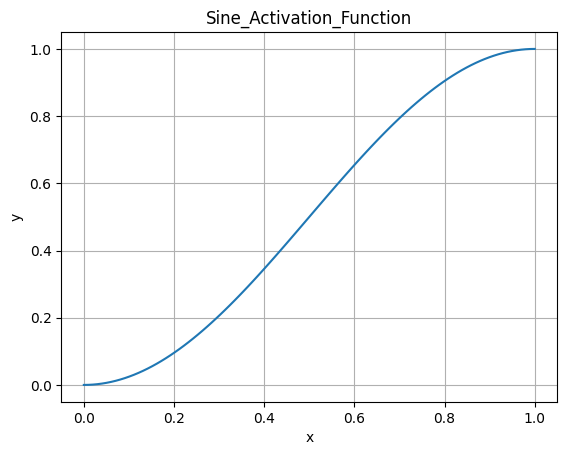

In [13]:
plot_sine_activation()

Print out model details including graph

Output = 472.33282470703125
{'fc1.weight': Parameter containing:
tensor([[ 7.3929e-01, -6.0593e-02,  3.4419e-01, -1.5496e-01,  8.6354e-02,
         -3.2721e-01,  6.0854e-01,  4.7748e-01, -3.4602e-01,  1.3640e+00,
         -4.8118e-01,  2.7941e-01, -8.3597e-01, -3.6796e-03],
        [ 6.0556e-01,  1.8260e-01,  1.9348e-01,  4.4920e-01, -2.3689e-02,
         -5.8886e-01, -1.6541e-01, -2.7060e-01, -7.4643e-01, -5.2364e-01,
         -4.3059e-01, -1.9778e-01, -1.3315e-01,  2.7996e-01],
        [-5.4230e-01,  7.6475e-01,  1.6645e+00,  9.7429e-01, -5.8677e-01,
          5.6829e-01,  1.5672e-01,  4.8724e-01, -1.3556e-01, -5.1865e-01,
         -5.2958e-01,  8.7457e-02,  1.1342e+00,  2.1293e-01],
        [-9.0521e-01,  6.3002e-01,  7.7713e-04,  4.3931e-01, -2.4566e-01,
          3.1551e-01, -2.2710e-01, -5.8458e-02,  4.5869e-01,  1.0078e-01,
          6.1993e-01,  9.0038e-02, -1.5619e-01, -2.1105e-02],
        [ 5.0532e-01,  1.3692e+00,  9.9508e-03,  4.4222e-01,  9.8945e-01,
         -1.1433e-01,

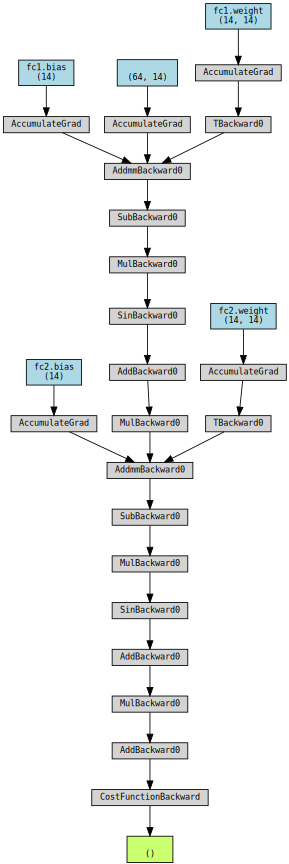

In [14]:
output = model(my_input)
lowest_cost = float(output)
print(f'Output = {output}')
filename = Path(GRAPH_DIR).joinpath('torchviz')

param_dict = dict(model.named_parameters())
print(param_dict)  # Debugging: print the parameters to ensure they seem reasonable
make_dot(output, params=param_dict).render(filename, format="png")
make_dot(output, params=param_dict)

Set up criterion, optimizer and target ready to train model.

In [16]:
target, criterion, optimizer = get_ready_to_train(model, OPTIMIZER, LR, WEIGHT_DECAY, momentum = MOMENTUM)

Train model and print out results:

In [18]:
lowest_cost, epoch_lowest_cost, epoch_hist, loss_hist = train_model(NUM_EPOCHS,
                                                                    model, 
                                                                    my_input, 
                                                                    target, 
                                                                    criterion,
                                                                    optimizer,
                                                                    print_results=True)

Epoch 0, Cost: 463.730, Lowest Cost to date =  463.730
Epoch 0, fc1.weight grad: 25434.74
Epoch 0, fc1.bias grad: 10383.69
Epoch 0, fc2.weight grad: 8878.51
Epoch 0, fc2.bias grad: 3931.48
Epoch 50, Cost: 484.572, Lowest Cost to date =  449.008
Epoch 50, fc1.weight grad: 35850.50
Epoch 50, fc1.bias grad: 14635.90
Epoch 50, fc2.weight grad: 12102.61
Epoch 50, fc2.bias grad: 5911.82


In [19]:
print(f'The lowest cost found was {lowest_cost:.3f} at epoch {epoch_lowest_cost}.')
print(f'The best known cost is {best_dist:.3f} and the hot start cost was {float(distance_tensor):.3f}.')

The lowest cost found was 449.008 at epoch 8.
The best known cost is 277.200 and the hot start cost was 315.800.


Plot loss ratio by epoch:

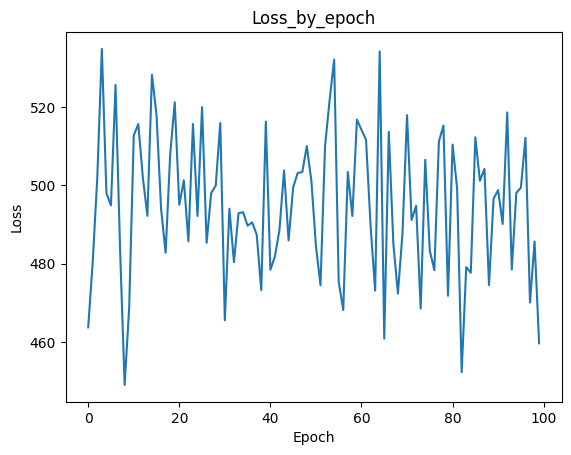

In [20]:
plot_model_training(epoch_hist, loss_hist)

Print out parameters:

In [21]:
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print('weight:', layer.weight)
        print('bias:', layer.bias)

weight: Parameter containing:
tensor([[ 7.3929e-01, -2.3255e+00,  3.4419e-01, -1.5496e-01, -2.1785e+00,
         -2.5921e+00,  6.0854e-01, -1.7874e+00, -3.4602e-01,  1.3640e+00,
         -4.8118e-01,  2.7941e-01, -3.1009e+00, -2.2686e+00],
        [ 6.0556e-01, -4.3427e+00,  1.9348e-01,  4.4920e-01, -4.5489e+00,
         -5.1141e+00, -1.6541e-01, -4.7959e+00, -7.4643e-01, -5.2364e-01,
         -4.3059e-01, -1.9778e-01, -4.6584e+00, -4.2453e+00],
        [-5.4230e-01, -6.3088e-01,  1.6645e+00,  9.7429e-01, -1.9824e+00,
         -8.2734e-01,  1.5672e-01, -9.0839e-01, -1.3556e-01, -5.1865e-01,
         -5.2958e-01,  8.7457e-02, -2.6142e-01, -1.1827e+00],
        [-9.0521e-01,  1.1906e+01,  7.7713e-04,  4.3931e-01,  1.1030e+01,
          1.1591e+01, -2.2710e-01,  1.1217e+01,  4.5869e-01,  1.0078e-01,
          6.1993e-01,  9.0038e-02,  1.1119e+01,  1.1254e+01],
        [ 5.0532e-01, -6.9951e-01,  9.9508e-03,  4.4222e-01, -1.0793e+00,
         -2.1831e+00, -2.0636e-01, -1.4551e+00, -7.6285e